# Pet-проект : EDA - Multiclass-classification

## Цель проекта - построение модели многоклассовой классификации для предсказании деапозона цен на мобильные устройства

## Задачи:

### 1. EDA
### 2. Найти новые признаки для обучения
### 3. Построение модели, подбор параметров для обучения, выбор лучшей
### 4. Предсказание на тестовом датасете

In [1]:
#Библиотеки для работы с данными 
import pandas as pd
import numpy as np
import math
from scipy.stats import mode
import warnings
warnings.filterwarnings("ignore")

#Библиотеки для визуализации данных
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.offline as pyo
import plotly.express as px
pyo.init_notebook_mode(connected=True)

#Библиотеки для машинного обучения
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report,f1_score
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [2]:
display(Image(url='https://filearchive.cnews.ru/img/book/2022/08/02/mobile_portable_devices_systems.png', 
              width = 1920) 
       )

# 1. Загрузка данных и проверка пропущенных значений

In [3]:
df = pd.read_csv('train.csv')

In [4]:
df.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


In [5]:
df.isna().sum()

battery_power    0
blue             0
clock_speed      0
dual_sim         0
fc               0
four_g           0
int_memory       0
m_dep            0
mobile_wt        0
n_cores          0
pc               0
px_height        0
px_width         0
ram              0
sc_h             0
sc_w             0
talk_time        0
three_g          0
touch_screen     0
wifi             0
price_range      0
dtype: int64

Пропущенные значения отсутствуют

# 2. EDA

## 2.1 Распределение классов ***(price_range)*** на карте

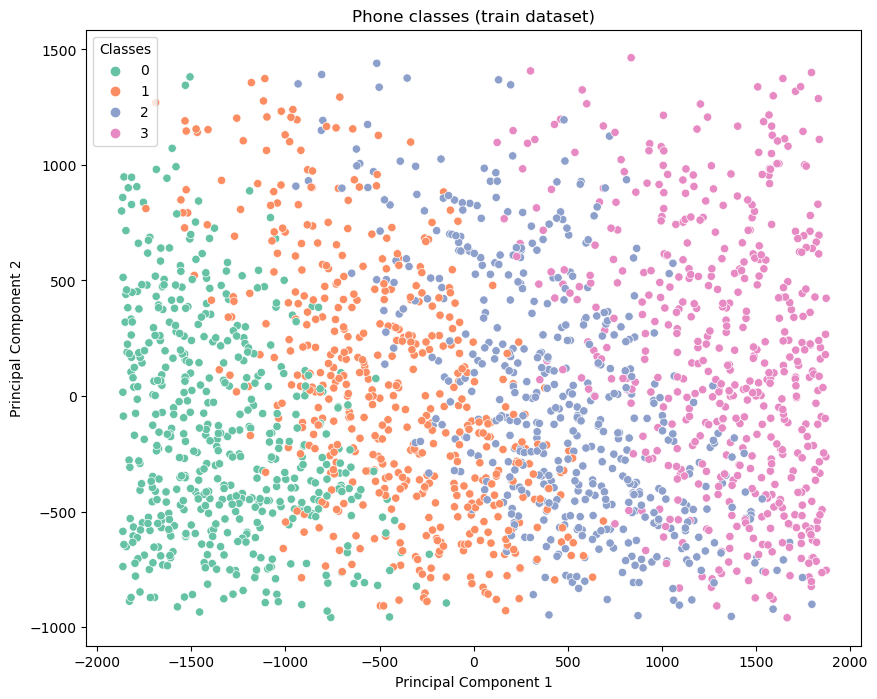

In [6]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(df.drop(columns=['price_range']))

pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Classes'] = df['price_range'].values

plt.figure(figsize=(10, 8))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Classes', palette='Set2', legend='full')
plt.title('Phone classes (train dataset)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

Напишим функцию для построение круговых диаграмм 

In [7]:
def pie_subplots(dataframe, columns, subplot_shape):
    num_subplots = len(columns)

    if num_subplots > 1:
        fig = make_subplots(rows=subplot_shape[0], cols=subplot_shape[1], subplot_titles=columns,
                            specs=[[{'type':'pie'}]*subplot_shape[1]]*subplot_shape[0],
                            horizontal_spacing=0.1, vertical_spacing=0.1)
    else:
        fig = make_subplots(rows=1, cols=1, subplot_titles=columns,
                            specs=[[{'type':'pie'}]])

    for i in range(num_subplots):
        col = columns[i]
        row_num = i // subplot_shape[1] + 1
        col_num = i % subplot_shape[1] + 1

        values = dataframe[col].value_counts()
        labels = values.index.tolist()
        counts = values.tolist()

        fig.add_trace(go.Pie(labels=labels, values=counts, textinfo='label+percent', hole=0.3),
                      row=row_num, col=col_num)

    fig.update_layout(height=290*subplot_shape[0], width=290*subplot_shape[1], title_text="Pie of binary columns")
    fig.show()

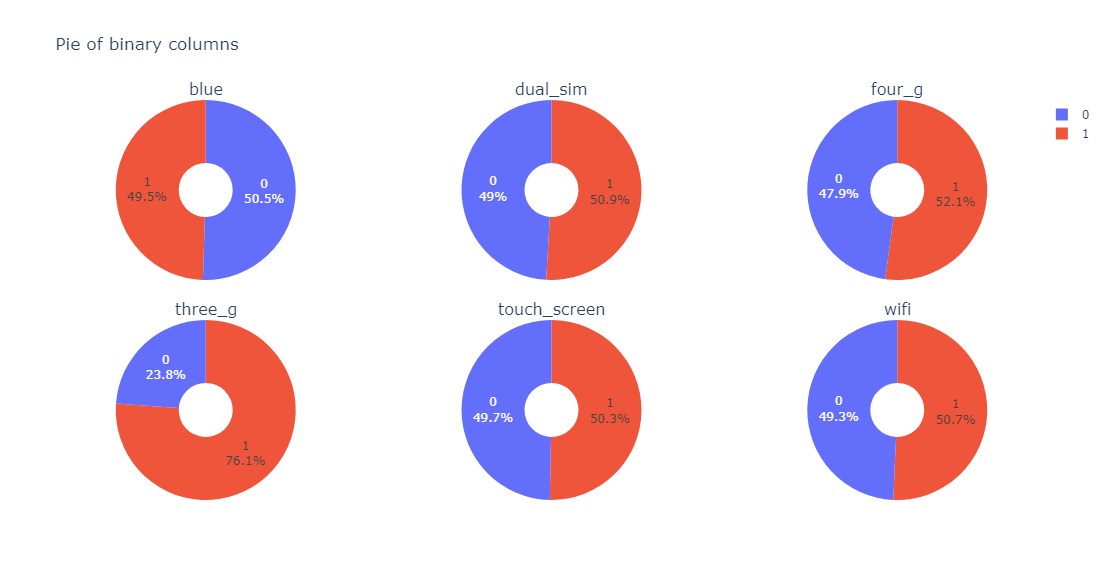

In [8]:
columns = ['blue','dual_sim','four_g','three_g','touch_screen','wifi']
pie_subplots(dataframe = df, columns = columns, subplot_shape = (2,3))

Напишем функцию для построения гистограмм

In [9]:
def histogram_subplots(data, columns, subplot_shape=(2, 2)):
    num_columns = len(columns)
    num_rows, num_cols = subplot_shape

    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 6*num_rows))

    for i, col in enumerate(columns, start=1):
        row_num = (i - 1) // num_cols
        col_num = (i - 1) % num_cols

        sns.histplot(data[col], kde=True, ax=axes[row_num, col_num])

    plt.tight_layout()
    plt.show()


## 2.2 Распределение числовых признаков

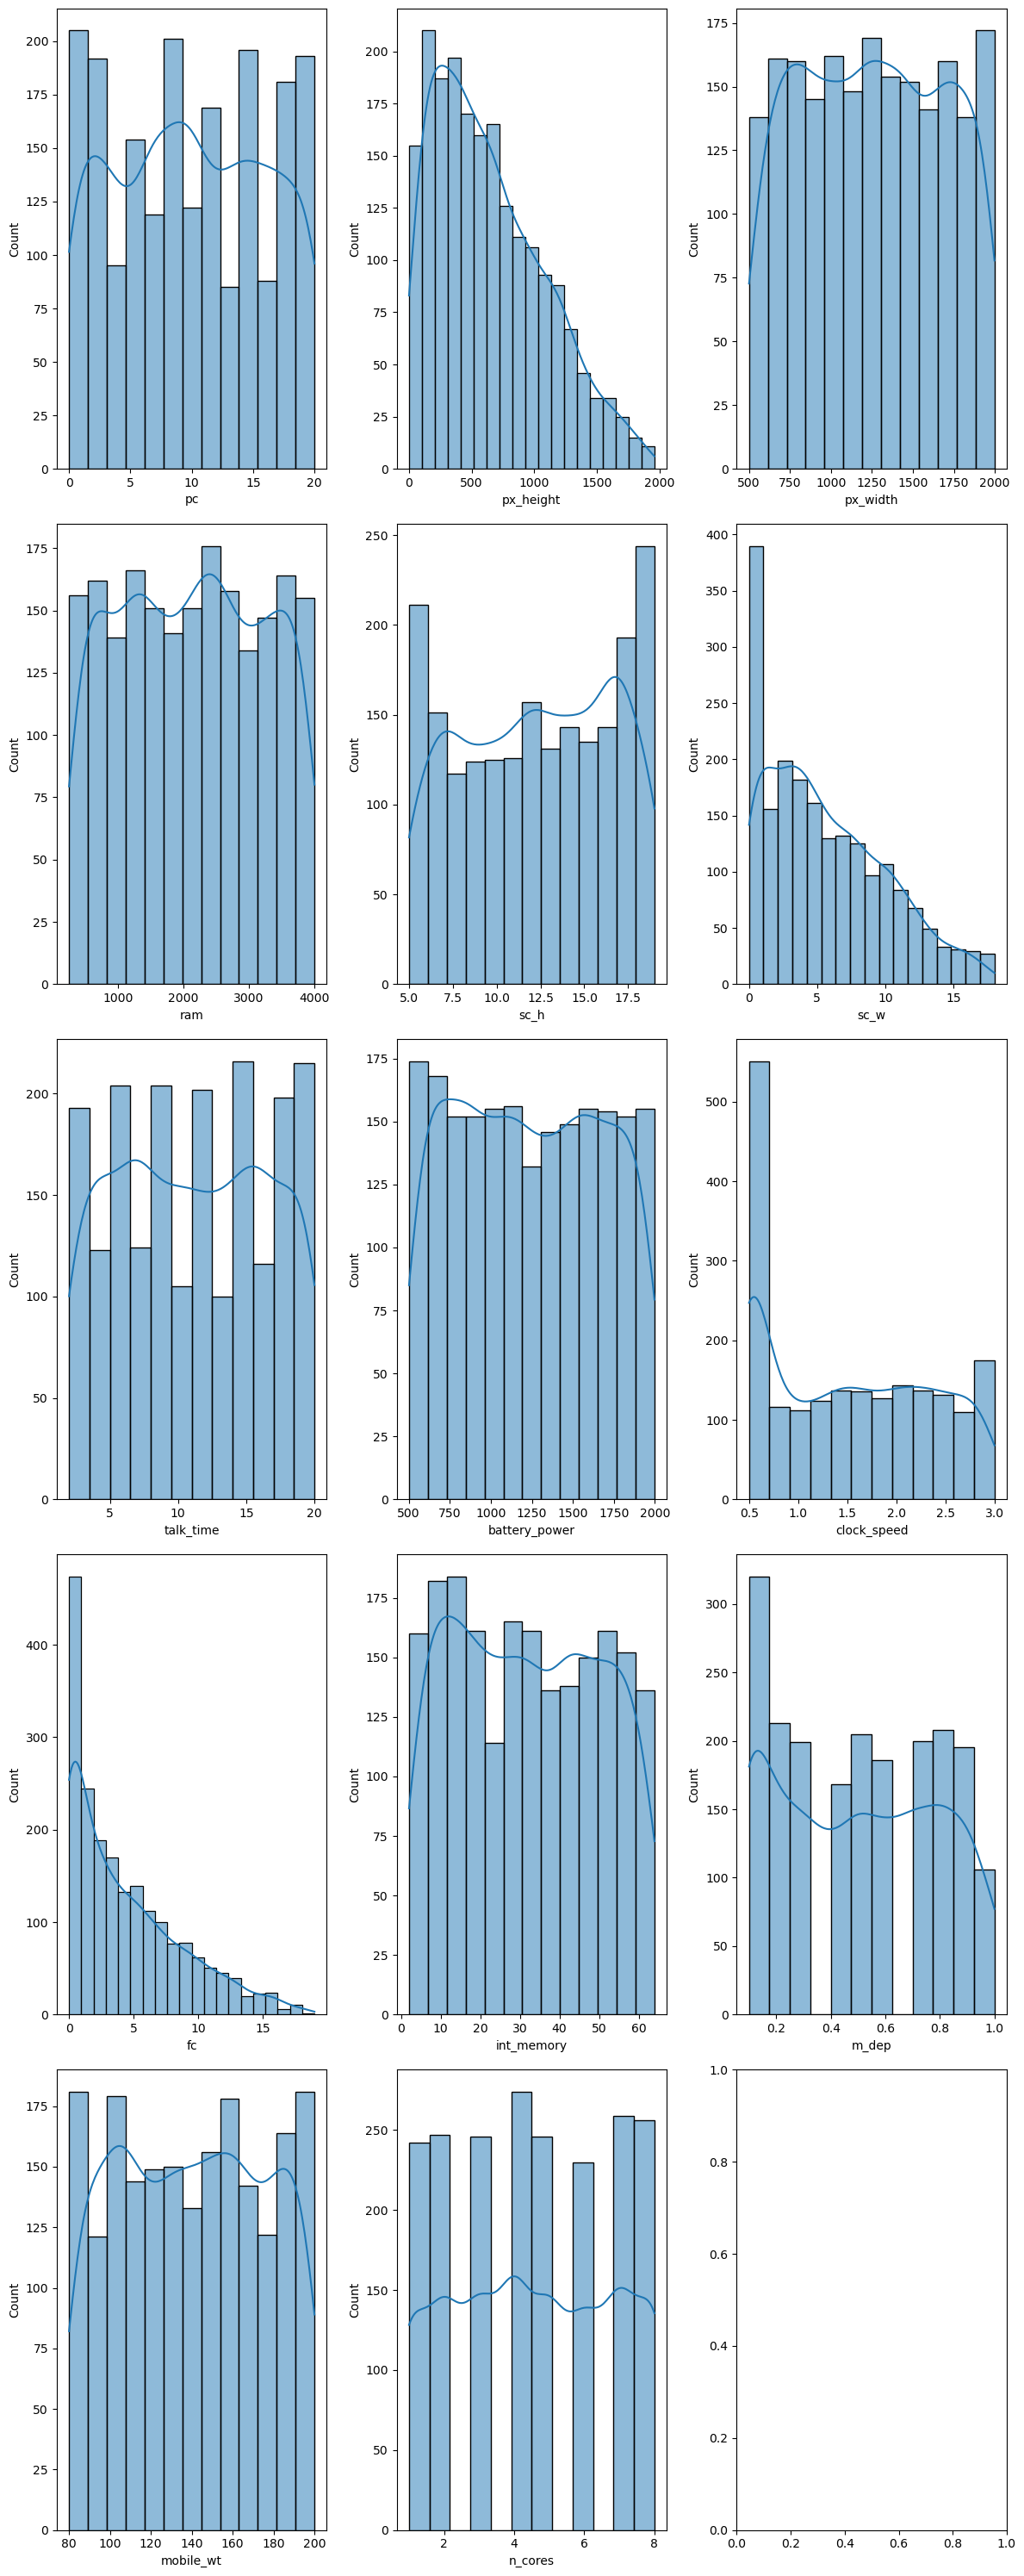

In [10]:
columns = ['pc','px_height','px_width','ram','sc_h','sc_w','talk_time',
          'battery_power','clock_speed','fc','int_memory','m_dep','mobile_wt','n_cores']

histogram_subplots(data = df, columns = columns, subplot_shape = (5,3))

## 2.3 Матрица корреляций

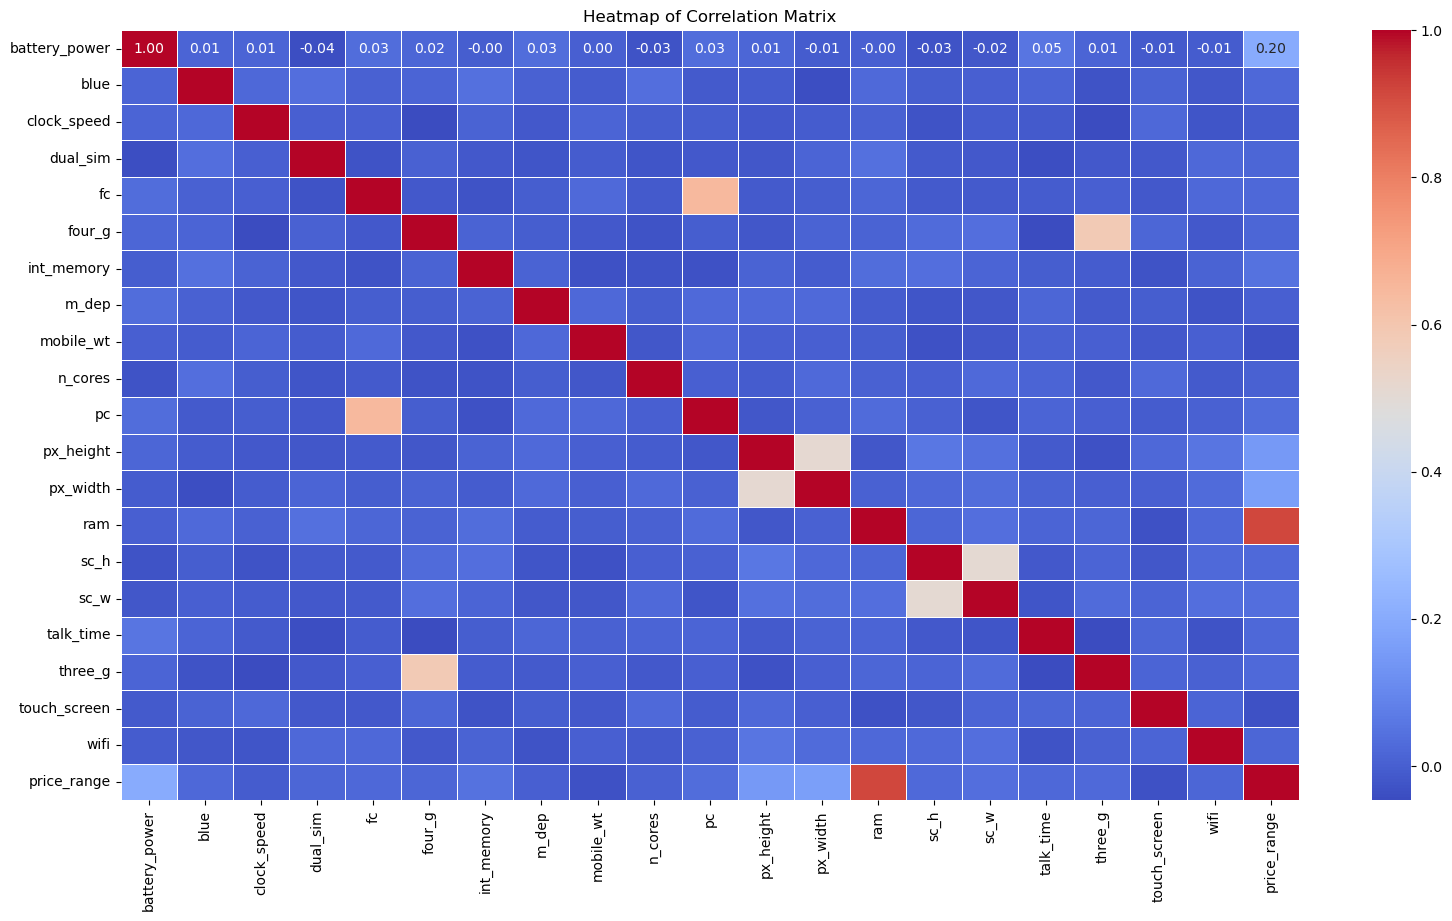

In [11]:
heatmap_data = df.corr()

plt.figure(figsize=(19, 10))
sns.heatmap(heatmap_data, annot=True, fmt='.2f', cmap='coolwarm', linewidths=.5)
plt.title('Heatmap of Correlation Matrix')
plt.show()

In [12]:
selected_column = 'price_range'
correlations = df.corrwith(df[selected_column])

correlations = correlations.abs()

sorted_correlations = correlations.sort_values(ascending=False)

print(f"Колонка, с которой сравниваем: {selected_column}")
print("10 Колонок, с которыми сильнее всего коррелирует:")
print(sorted_correlations[1:10])

Колонка, с которой сравниваем: price_range
10 Колонок, с которыми сильнее всего коррелирует:
ram              0.917046
battery_power    0.200723
px_width         0.165818
px_height        0.148858
int_memory       0.044435
sc_w             0.038711
pc               0.033599
touch_screen     0.030411
mobile_wt        0.030302
dtype: float64


In [13]:
sorted_correlations = sorted_correlations[1:11].reset_index()

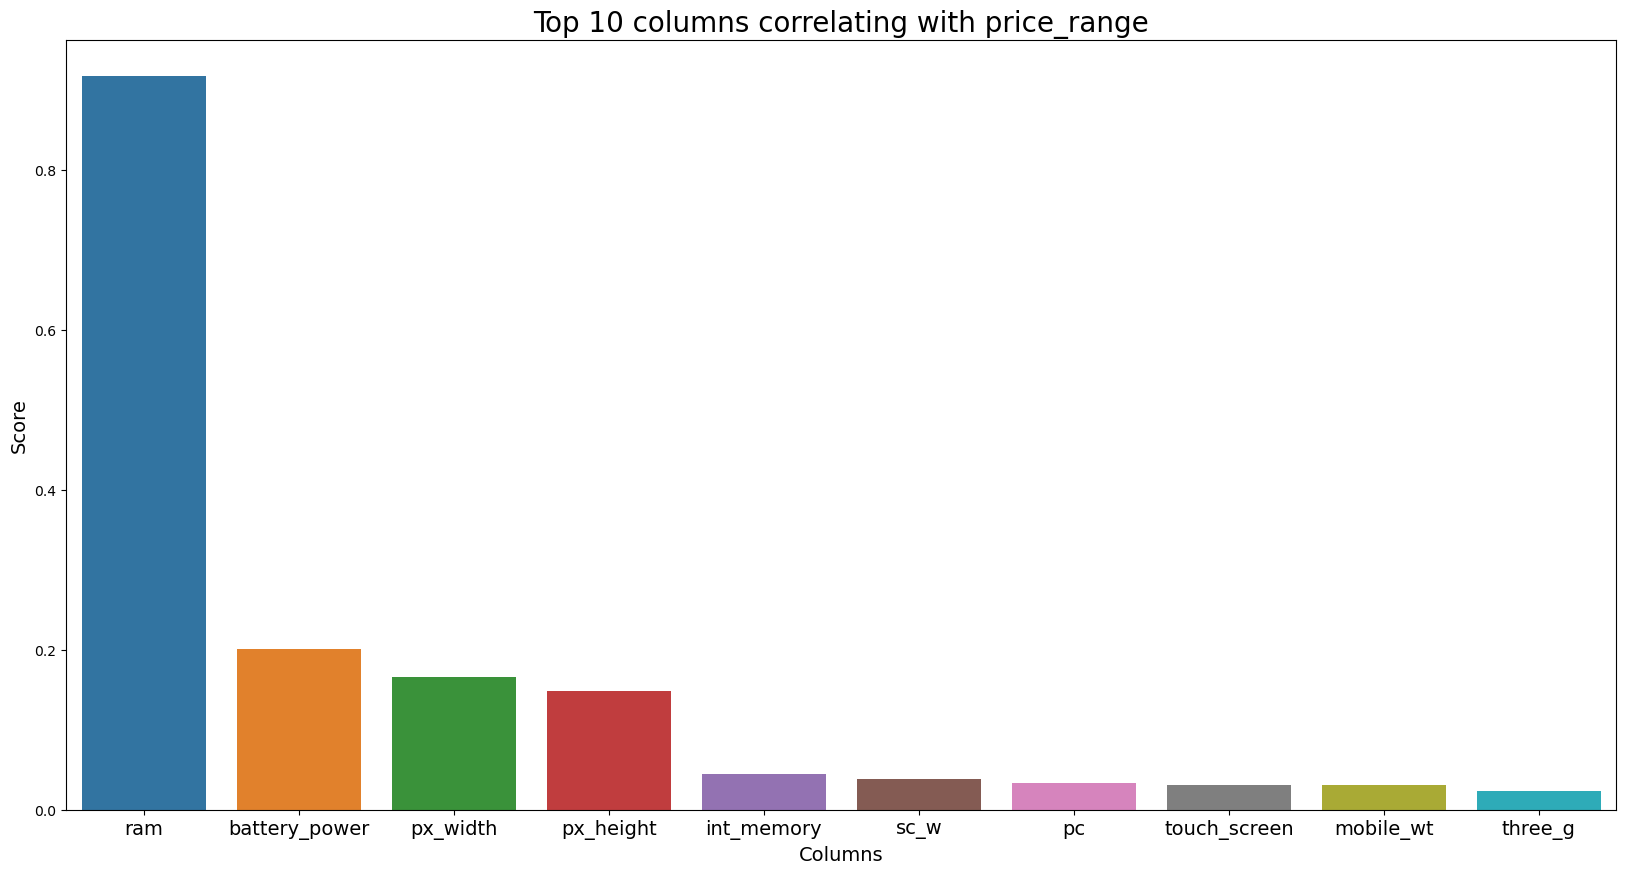

In [14]:
fig, ax = plt.subplots(figsize=(20, 10))
fig = sns.barplot(data=sorted_correlations, x='index', y=0)
plt.xticks(fontsize=14)
plt.title('Top 10 columns correlating with price_range',fontsize=20)
plt.ylabel('Score',fontsize=14)
plt.xlabel('Columns',fontsize=14)
plt.show()

Сделаем датафрейм со средними характеристиками в зависимости от класса ***(price_range)***

In [15]:
columns_to_aggregate1 = ['blue','dual_sim','four_g','three_g','touch_screen','wifi']
columns_to_aggregate2 = ['pc','px_height','px_width','ram','sc_h','sc_w','talk_time',
                        'battery_power','clock_speed','fc','int_memory','m_dep',
                         'mobile_wt','n_cores']

def custom_mode(x): # Функция для агрегации по моде для бинарных колонок
    mode_result = mode(x)
    if np.isscalar(mode_result.mode):
        return mode_result.mode
    elif len(mode_result.mode) == 0:
        return None 
    else:
        return mode_result.mode[0]

df_grouped_1 = df.groupby('price_range')[columns_to_aggregate1].agg(custom_mode)
df_grouped_2 = df.groupby('price_range')[columns_to_aggregate2].median()

df_grouped = pd.merge(df_grouped_1, df_grouped_2, on='price_range').reset_index()

In [16]:
df_grouped

,price_range,blue,dual_sim,four_g,three_g,touch_screen,wifi,pc,px_height,px_width,...,sc_h,sc_w,talk_time,battery_power,clock_speed,fc,int_memory,m_dep,mobile_wt,n_cores
0,0,0,0,1,1,1,0,9.5,465.5,1132.5,...,12.0,5.0,10.0,1066.0,1.55,3.0,30.0,0.5,142.0,5.0
1,1,0,1,1,1,1,1,10.0,606.0,1223.0,...,12.0,5.0,12.0,1206.0,1.50,3.0,32.0,0.5,141.0,4.0
2,2,0,0,0,1,0,1,10.0,538.5,1221.5,...,12.0,5.0,11.0,1219.5,1.50,3.0,30.0,0.5,145.0,5.0
3,3,1,1,1,1,0,1,10.0,674.0,1415.5,...,13.0,5.0,11.0,1449.5,1.50,3.0,34.5,0.5,134.0,5.0


In [17]:
def barcharts_subplots(df, category_col, columns_to_plot, subplot_shape):
    num_subplots = len(columns_to_plot)
    num_rows, num_cols = subplot_shape

    if num_subplots > (num_rows * num_cols):
        raise ValueError(f"Ошибка: Недостаточно подграфиков для количества колонок ({num_subplots})")

    category_colors = px.colors.qualitative.Set1[:len(df[category_col].unique())]

    fig = make_subplots(rows=num_rows, cols=num_cols, subplot_titles=columns_to_plot)

    for i, col in enumerate(columns_to_plot, 1):
        row_num = (i - 1) // num_cols + 1
        col_num = (i - 1) % num_cols + 1

        for j, category_value in enumerate(df[category_col].unique()):
            subset_df = df[df[category_col] == category_value]
            bar_chart = go.Bar(x=subset_df[category_col], y=subset_df[col],
                               name=f'{col}_{category_value}', marker_color=category_colors[j])
            fig.add_trace(bar_chart, row=row_num, col=col_num)

    fig.update_layout(
        height=900, width=900,
        showlegend=False,
        title_text='Bar Plots for Different Columns across Price range',
        xaxis_title='Price range',
        yaxis_title='Values'
    )
    
    fig.show()

## 2.4 Гистограммы для числовых признаков в зависимости от класса ***(price_range)***

In [18]:
barcharts_subplots(df_grouped,'price_range',columns_to_aggregate2,(5,3))

Итог:
1. По построенным гистограммам числовых признаков можно увидеть, что присутствуют выбросы
2. С таргетной переменной **price_range** больше всего коррелируют такие признаки : **ram, battery_power, px_width, px_height, int_memory** 



# 3. Создание новых признаков и очистка от выбросов

## 3.1 Признак "Разрешение дисплея"

Суть признака заключается в том, чтобы перемножить высоту и ширину пикселей, а затем сопоставить полученное разрешение с данными из [таблицы разрешений](https://en.wikipedia.org/wiki/Display_resolution). Если разрешение принадлежит какому-либо промежутку из таблицы, присвоим признаку значение 1, в противном случае - 0.

In [19]:
df['display_resolution'] = df['px_height'] * df['px_width']

In [20]:
def resolution(row): #Функция для нахождения разрешения
    if 0 < row < 921600:
        return '240p'
    elif 921600 <= row < 1440000:
        return 'HD'
    elif 1440000 <= row < 2073600:
        return 'HD+'
    elif 2073600 <= row < 2211840:
        return 'FHD'
    elif 2211840 <= row < 2764800:
        return '2K'
    elif 2764800 <= row < 3686400:
        return 'UWHD'
    elif 3686400 <= row < 4953600:
        return 'QHD'
    elif 4953600 <= row < 8294400:
        return 'Ultra WQHD'
    elif row >= 8294400:
        return '4K'

In [21]:
df['resolution'] = df['display_resolution'].apply(resolution)

### 3.1.1 Распределение разрешний мобильных устройств

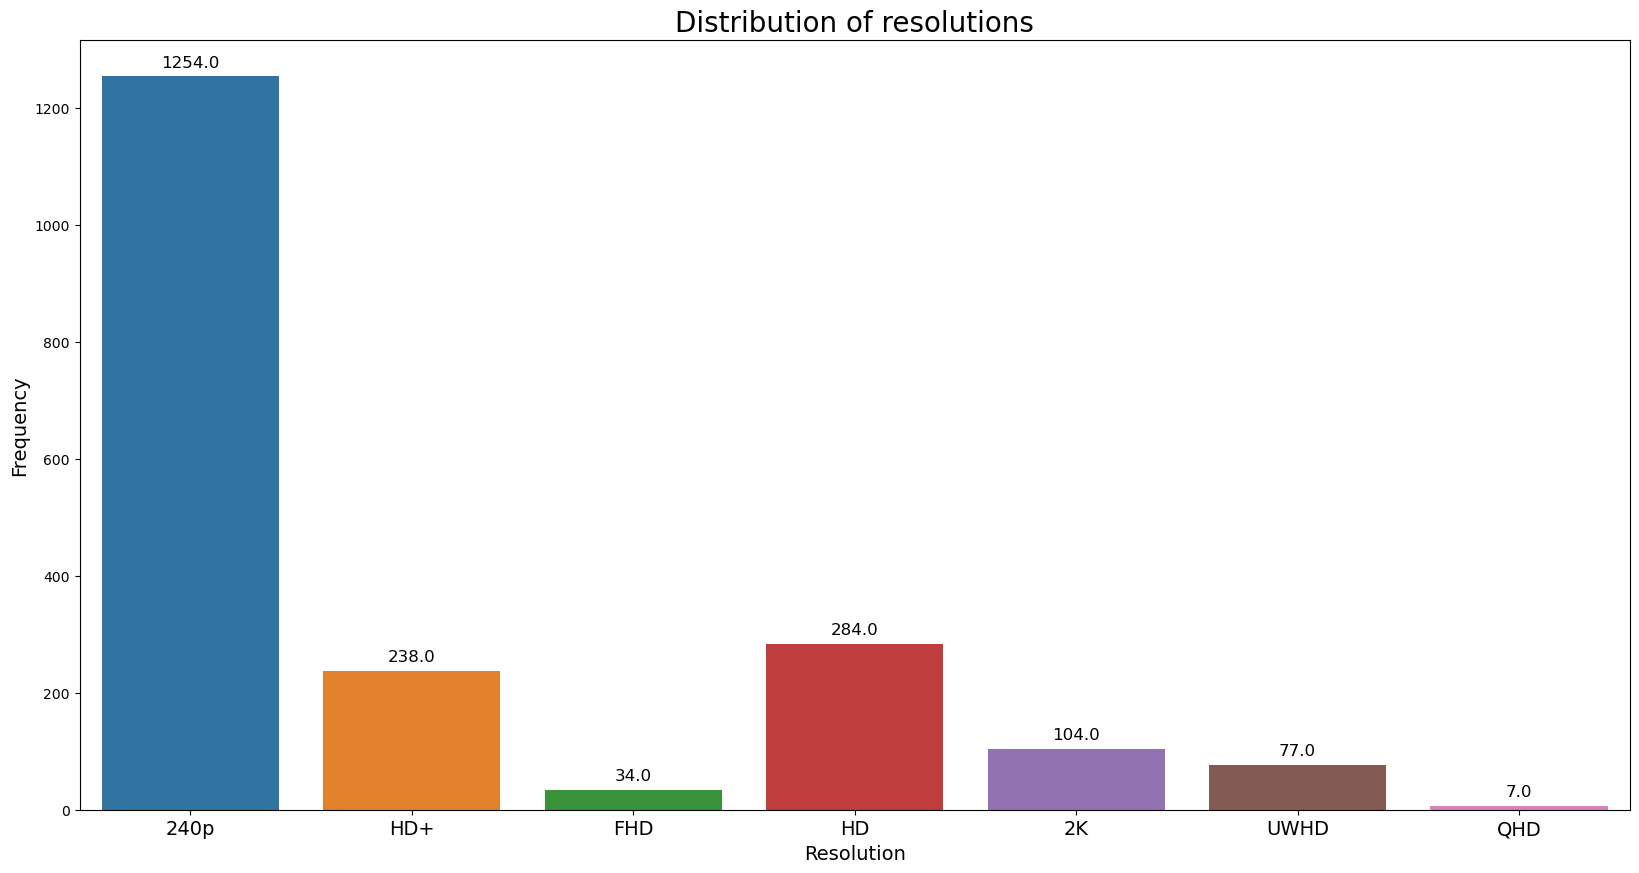

In [22]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.countplot(data=df, x='resolution', ax=ax)

plt.xticks(fontsize=14)
plt.title('Distribution of resolutions', fontsize=20)
plt.ylabel('Frequency', fontsize=14)
plt.xlabel('Resolution', fontsize=14)

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=12)

plt.show()

## 3.2 Признак "Диагональ дисплея"

Данный признак вычисляет физическую длину диагонали экрана мобильного устройства в дюймах на основе его ширины и высоты в сантиметрах, а также разрешения экрана в пикселях.Для вычисления физической длины диагонали используется формула, основанная на теореме Пифагора:
$\sqrt{{ширина\_пикселей}^2 + {высота\_пикселей}^2}$
Затем, используя соотношение между длиной в пикселях и длиной в сантиметрах (плотность пикселей), мы переводим длину диагонали в пикселях в длину в дюймах. 


У нас имеются в датафрейме столбцы с широной дисплея равной 0, это помешает подсчёту диагонали, поэтому удалим их

In [23]:
df[df['sc_w'] == 0]

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range,display_resolution,resolution
12,1815,0,2.8,0,2,0,33,0.6,159,4,...,1482,18,0,2,1,0,0,1,454036,240p
24,503,0,1.2,1,5,1,8,0.4,111,3,...,2583,11,0,12,1,0,0,1,250245,240p
33,1310,1,2.2,1,0,1,51,0.6,100,4,...,3845,7,0,12,1,1,0,3,341582,240p
42,1253,1,0.5,1,5,1,5,0.2,152,2,...,1878,15,0,4,1,1,0,1,489090,240p
50,1547,1,3.0,1,2,1,14,0.7,198,3,...,2059,5,0,15,1,0,1,2,1908944,HD+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1918,772,0,1.0,1,0,1,23,0.6,97,7,...,2782,7,0,17,1,0,0,2,572185,240p
1920,591,1,0.5,1,1,1,16,0.9,90,6,...,3746,5,0,5,1,1,0,3,1429876,HD
1946,590,1,1.2,1,0,0,32,0.4,141,6,...,1817,10,0,6,0,1,0,0,115543,240p
1954,686,1,2.7,1,0,0,36,0.1,194,4,...,1503,10,0,13,0,0,0,0,47680,240p


In [24]:
df = df[df['sc_w'] > 0]

In [25]:
def calculate_diagonal_inches(row): # функция для подсчёта дюймов
    width_cm = row['sc_w'] 
    height_cm = row['sc_h']
    width_pixels = row['px_width']
    height_pixels = row['px_height']

    dpi = width_pixels / width_cm
    diagonal_pixels = math.sqrt(width_pixels**2 + height_pixels**2)
    diagonal_inches = diagonal_pixels / dpi

    return round(diagonal_inches,1)

In [26]:
df['inch'] = df.apply(calculate_diagonal_inches,axis=1)

### 3.2.1 Распределение диагонали дисплея мобильных устройств

Text(0, 0.5, 'Frequent')

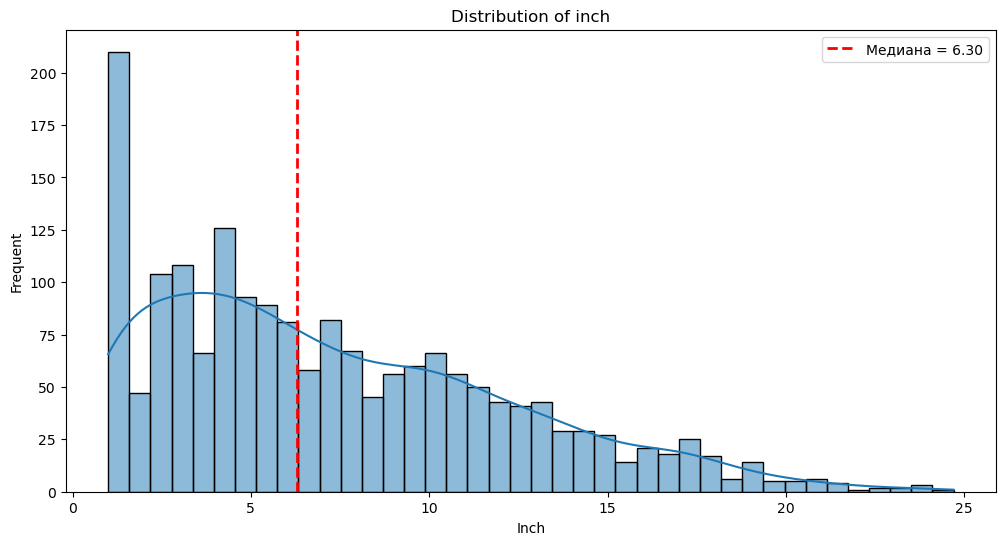

In [27]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(df, x = 'inch', bins=40, kde=True)
median_value = np.median(df['inch'])
plt.axvline(median_value, color='red', linestyle='dashed', linewidth=2, label=f'Медиана = {median_value:.2f}')
plt.legend()
plt.title('Distribution of inch')
plt.xlabel('Inch')
plt.ylabel('Frequent')

## 3.3 Очистка от выбросов числовых признаков

In [28]:
numeric_columns = df.select_dtypes(include=['number']).columns
Q1_numeric = df[numeric_columns].quantile(0.25)
Q3_numeric = df[numeric_columns].quantile(0.75)
IQR_numeric = Q3_numeric - Q1_numeric
outlier_cutoff_numeric = 1.5 * IQR_numeric

df_filtered = df[~((df[numeric_columns] < (Q1_numeric - outlier_cutoff_numeric)) | (df[numeric_columns] > (Q3_numeric + outlier_cutoff_numeric))).any(axis=1)]

Итог:
1. Добавлены два признака "Разрешение дисплея" и "Диагональ дисплея"
3. Произведена очистка от выбросов

# 4. Построение моделей многоклассовой классификации

## 4.1 Подготовка данных

In [29]:
df_filtered = df_filtered.drop(['px_height','px_width','sc_h','sc_w','display_resolution'],axis=1)
df_filtered = pd.get_dummies(df_filtered, columns=['resolution'], prefix=['resolution'], drop_first=True)

In [30]:
y = df_filtered['price_range']
X = df_filtered.drop('price_range',axis=1)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 4.2 Обучение моделей RF, XGBoost, Catboost, MLP

In [32]:
pipe_RF = Pipeline(
[('Scaler',StandardScaler()),
 ('RF',RandomForestClassifier())
])
param_grid = {
    'RF__n_estimators': [100],  
    'RF__max_depth': [15],
    'RF__min_samples_leaf': [2],
    'RF__min_samples_split': [5],
    'RF__bootstrap': [False]
}

grid_search = GridSearchCV(pipe_RF, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train) 

best_model_RF = grid_search.best_estimator_

In [33]:
y_pred = best_model_RF.predict(X_test)
report = classification_report(y_test, y_pred)
accuracy_score_RF = accuracy_score(y_test, y_pred)
f1_score_RF = f1_score(y_test, y_pred, average = 'weighted')
print(report)
print(grid_search.best_params_)

              precision    recall  f1-score   support

           0       0.82      0.92      0.87        64
           1       0.73      0.68      0.70        66
           2       0.73      0.79      0.76        71
           3       0.94      0.80      0.86        64

    accuracy                           0.80       265
   macro avg       0.80      0.80      0.80       265
weighted avg       0.80      0.80      0.80       265

{'RF__bootstrap': False, 'RF__max_depth': 15, 'RF__min_samples_leaf': 2, 'RF__min_samples_split': 5, 'RF__n_estimators': 100}


In [34]:
pipe_Ragdoll = Pipeline([
    ('Scaler',StandardScaler()),
    ('Cat',CatBoostClassifier(verbose=False))])

param_grid = {
    'Cat__learning_rate':  [0.2],
    'Cat__iterations': [300],
    'Cat__depth': [12]
}
grid_search = GridSearchCV(pipe_Ragdoll, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                       ('Cat',
                                        <catboost.core.CatBoostClassifier object at 0x000001DA3468DE90>)]),
             param_grid={'Cat__depth': [12], 'Cat__iterations': [300],
                         'Cat__learning_rate': [0.2]},
             scoring='accuracy')

In [35]:
best_model_Cat = grid_search.best_estimator_
y_pred = best_model_Cat.predict(X_test)
report = classification_report(y_test, y_pred)
accuracy_score_Cat = accuracy_score(y_test, y_pred)
f1_score_Cat = f1_score(y_test, y_pred, average = 'weighted')
print(report)
print(grid_search.best_params_)

              precision    recall  f1-score   support

           0       0.83      0.94      0.88        64
           1       0.75      0.74      0.75        66
           2       0.80      0.79      0.79        71
           3       0.95      0.86      0.90        64

    accuracy                           0.83       265
   macro avg       0.83      0.83      0.83       265
weighted avg       0.83      0.83      0.83       265

{'Cat__depth': 12, 'Cat__iterations': 300, 'Cat__learning_rate': 0.2}


In [36]:
pipe_XGBoost = Pipeline([
    ('Scaler', StandardScaler()), 
    ('XGB', XGBClassifier())     
])

param_grid = {
    'XGB__learning_rate': [0.1, 0.2],
    'XGB__n_estimators': [200, 300],
    'XGB__max_depth': [3, 5, 7]
}

grid_search = GridSearchCV(pipe_XGBoost, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                       ('XGB',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gamma=None,
                                                      grow_policy=None,
                                                      importance_type=No...
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...))]),
             param_grid={'XGB__learning_rate': [0.1, 0.2],
                         'XGB__max_depth': [3, 5, 7],
                         'XGB__n_estimators': [200, 300]},
             scoring='accuracy')

In [37]:
best_model_XGBoost = grid_search.best_estimator_
y_pred = best_model_XGBoost.predict(X_test)
report = classification_report(y_test, y_pred)
accuracy_score_XGBoost = accuracy_score(y_test, y_pred)
f1_score_XGBoost = f1_score(y_test, y_pred, average = 'weighted')
print(report)
print(grid_search.best_params_)

              precision    recall  f1-score   support

           0       0.87      0.94      0.90        64
           1       0.80      0.77      0.78        66
           2       0.83      0.82      0.82        71
           3       0.94      0.91      0.92        64

    accuracy                           0.86       265
   macro avg       0.86      0.86      0.86       265
weighted avg       0.86      0.86      0.86       265

{'XGB__learning_rate': 0.1, 'XGB__max_depth': 3, 'XGB__n_estimators': 200}


In [38]:
pipe_MLP = Pipeline([
    ('Scaler', StandardScaler()),
    ('MLP', MLPClassifier(verbose=False))
])

param_grid = {
    'MLP__activation': ['logistic'],
    'MLP__learning_rate': ['invscaling'],
    'MLP__max_iter': [800],
    'MLP__solver': ['adam'],
}

grid_search = GridSearchCV(pipe_MLP, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)

best_model_MLP = grid_search.best_estimator_

In [39]:
best_model_MLP = grid_search.best_estimator_
y_pred = best_model_MLP.predict(X_test)
report = classification_report(y_test, y_pred)
accuracy_score_MLP = accuracy_score(y_test, y_pred)
f1_score_MLP = f1_score(y_test, y_pred, average = 'weighted')
print(report)
print(grid_search.best_params_)

              precision    recall  f1-score   support

           0       0.94      0.95      0.95        64
           1       0.88      0.89      0.89        66
           2       0.88      0.85      0.86        71
           3       0.91      0.92      0.91        64

    accuracy                           0.90       265
   macro avg       0.90      0.90      0.90       265
weighted avg       0.90      0.90      0.90       265

{'MLP__activation': 'logistic', 'MLP__learning_rate': 'invscaling', 'MLP__max_iter': 800, 'MLP__solver': 'adam'}


In [40]:
columns = ['model','accuracy','f1_score']

dataframe = [
    ['RF', accuracy_score_RF, f1_score_RF],
    ['XGBoost', accuracy_score_XGBoost, f1_score_XGBoost],
    ['CatBoost', accuracy_score_Cat, f1_score_Cat], 
    ['MLP', accuracy_score_MLP, f1_score_MLP],
]

data_metrics = pd.DataFrame(dataframe, columns=columns)

In [41]:
data_metrics

,model,accuracy,f1_score
0,RF,0.796226,0.796179
1,XGBoost,0.856604,0.856079
2,CatBoost,0.830189,0.829988
3,MLP,0.901887,0.901589


### 4.3 Сравнение моделей по метрикам Accuracy, f1_score

In [42]:
models = data_metrics['model']
accuracy = data_metrics['accuracy']
f1_score = data_metrics['f1_score']

pyo.init_notebook_mode(connected=True)
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, subplot_titles=['accuracy', 'f1-score'])

fig.add_trace(go.Bar(x=models, y=accuracy, name='accuracy'), row=1, col=1)
fig.add_trace(go.Bar(x=models, y=f1_score, name='f1-score'), row=2, col=1)
fig.update_layout(
    barmode='group',
    title_text='Comparison of metrics for different models',
    showlegend=False 
)

fig.show()

Итог: по результатам обучения лучше всего показала себя модель MLP

# 5. Предсказание на тестовом датасете 

## 5.1 Загрузка датасета

In [43]:
data_test = pd.read_csv('test.csv')

In [44]:
data_test.isna().sum()

id               0
battery_power    0
blue             0
clock_speed      0
dual_sim         0
fc               0
four_g           0
int_memory       0
m_dep            0
mobile_wt        0
n_cores          0
pc               0
px_height        0
px_width         0
ram              0
sc_h             0
sc_w             0
talk_time        0
three_g          0
touch_screen     0
wifi             0
dtype: int64

In [45]:
data_test.head()

,id,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,...,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
0,1,1043,1,1.8,1,14,0,5,0.1,193,...,16,226,1412,3476,12,7,2,0,1,0
1,2,841,1,0.5,1,4,1,61,0.8,191,...,12,746,857,3895,6,0,7,1,0,0
2,3,1807,1,2.8,0,1,0,27,0.9,186,...,4,1270,1366,2396,17,10,10,0,1,1
3,4,1546,0,0.5,1,18,1,25,0.5,96,...,20,295,1752,3893,10,0,7,1,1,0
4,5,1434,0,1.4,0,11,1,49,0.5,108,...,18,749,810,1773,15,8,7,1,0,1


## 5.2 Подготовка данных

In [46]:
data_test = data_test[data_test['sc_w'] > 0]

data_test['display_resolution'] = data_test['px_height'] * data_test['px_width']
data_test['resolution'] = data_test['display_resolution'].apply(resolution)

data_test['inch'] = data_test.apply(calculate_diagonal_inches,axis=1)

numeric_columns = data_test.select_dtypes(include=['number']).columns
Q1_numeric = data_test[numeric_columns].quantile(0.25)
Q3_numeric = data_test[numeric_columns].quantile(0.75)
IQR_numeric = Q3_numeric - Q1_numeric
outlier_cutoff_numeric = 1.5 * IQR_numeric

data_test_filtered = data_test[~((data_test[numeric_columns] < (Q1_numeric - outlier_cutoff_numeric))
                          | (data_test[numeric_columns] > (Q3_numeric + outlier_cutoff_numeric))).any(axis=1)]

data_test_filtered = data_test_filtered.drop(['px_height','px_width','sc_h','sc_w','display_resolution'],axis=1)
data_test_filtered = pd.get_dummies(data_test_filtered, columns=['resolution'], prefix=['resolution'], drop_first=True)

X = data_test_filtered
X = X.drop('id',axis=1)

## 5.3 Предсказание модели MLP и построение графика распределения классов **(price_range)**

In [47]:
X['prediction_of_model'] = best_model_MLP.predict(X)

In [48]:
X.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,three_g,touch_screen,wifi,inch,resolution_2K,resolution_FHD,resolution_HD,resolution_HD+,resolution_UWHD,prediction_of_model
4,1434,0,1.4,0,11,1,49,0.5,108,6,...,1,0,1,10.9,False,False,False,False,False,1
5,1464,1,2.9,1,5,1,50,0.8,198,8,...,1,1,1,8.2,False,False,False,False,False,3
8,1111,1,2.9,1,9,1,25,0.6,101,5,...,1,1,0,10.7,False,False,False,False,False,3
11,1343,0,2.9,0,2,1,34,0.8,171,3,...,1,1,1,8.1,False,False,False,False,False,3
12,900,1,1.4,1,0,0,30,1.0,87,2,...,1,0,0,2.2,False,False,False,True,False,0


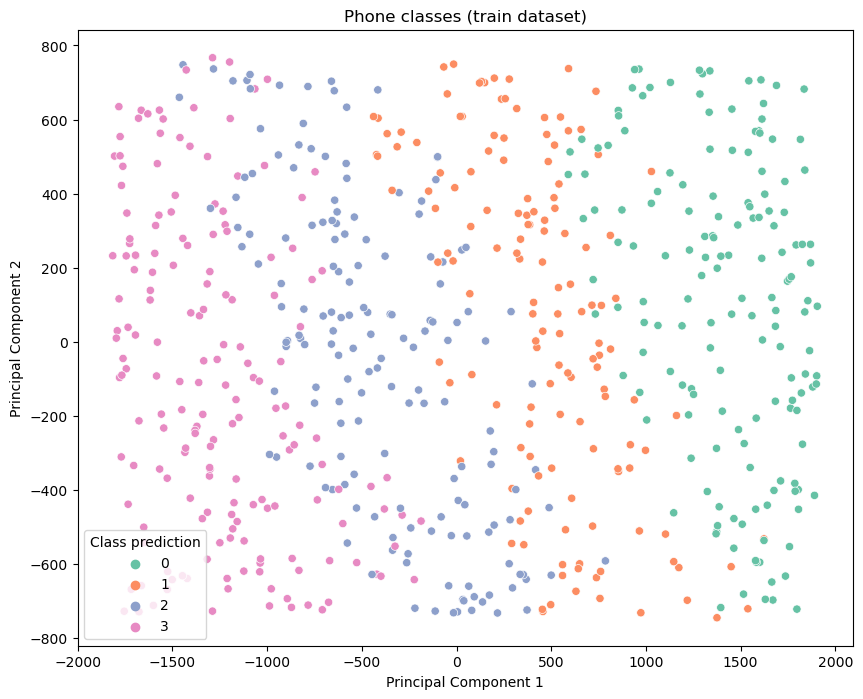

In [49]:
# Применяем PCA для снижения размерности до двух компонент
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X.drop(columns=['prediction_of_model']))

pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Class prediction'] = X['prediction_of_model'].values

plt.figure(figsize=(10, 8))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Class prediction', palette='Set2', legend='full')
plt.title('Phone classes (train dataset)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


Итог: по графику "Phone classes (train dataset)" мы можем видеть очертание областей классов, что подтверждает эффективность данной модели.

# 6. Итог

## В результате выполненной работы была разработана модель многоклассовой классификации, а именно наилучшей по показателям (accuracy, f1-score) стала модель MLP. 